implementation code and numerical examples for the article: 

Axes that matter: PCA with a difference

by Brian Huge and Antoine Savine (Risk, 2021) 


        --- coming soon ---

In [1]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

Not running on CoLab


In [378]:
epsilon = 1.0e-8
one_minus_eps = 1.0 - epsilon

class DiffPCA:
    
    def __init__(self, n_components=one_minus_eps, central=False):
        """
        The API is consistent with sklearn.decomposition.PCA 
        (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
        
        n_components = number of components to keep. If n_components is None all components are kept:
        n_components == n_features
        
        If 0 < n_components < 1, select the number of components such that 
        the amount of 'variance' (squared magnitude) that needs to be explained is greater than the percentage specified by n_components
        
        Default = squared error magnitude (epsilon*total_variance in the article) of 10^(-8), i.e. error norm is 0.01% of total norm
                        
        central = specific to differential PCA, standard scikit-learn PCA is always central. By contrast, 
        differential PCA is noncentral by default, see article
        """
        
        self.n_components = n_components
        self.central = central
        
    def fit(self, X, Z, y=None): # note y is ignored, just like in scikit-learn PCA
        """
        X: input data
        Z: differential data = dy/dZ, see article
        (y: labels)
        """
        
        # copy data
        self.X = X.copy() 
        self.y = y.copy() if y else None
        self.Z = Z.copy() 
        self.n_samples_, self.n_features_ = self.X.shape
        
        # central?
        self.mean_ = self.Z.mean(axis=0) # average differentials
        if self.central: self.Z -= self.mean_ # demean differentials
            
        # compute covariance matrix of differentials
        self.cov_ = self.Z.T @ self.Z / self.n_samples_
        
        # eigenvalue decomposition
        d, P = np.linalg.eigh(self.cov_)
                
        # reverse order so largest eigenvalues come first
        d = d[::-1]
        P = P[:, ::-1]
        
        sumd = np.cumsum(d)
        total_variance = sumd[-1]

        # filter
        if self.n_components is not None: 
            # n_components is larger than 1 = number of components
            if self.n_components >= 1:
                self.n_components_ = self.n_components
            # n_components is smaller than 1 = square magnitude explained
            else:
                sumd /= total_variance
                self.n_components_ = np.searchsorted(sumd, self.n_components) + 1
            
            explained = sumd[self.n_components_-1]
            unexplained = total_variance - explained
                
            d = d[:self.n_components_]
            P = P[:, :self.n_components_]

        # results, attributes as in sklearn.decomposition.PCA
        self.components_ = P.T
        self.explained_variance_ = d
        self.explained_variance_ratio_ = d / total_variance
        self.singular_values_ = np.sqrt(d)
        self.noise_variance_ = unexplained
        
    def transform(self, X, Z=None): 
        
        # transformed dataset
        L = X @ self.components_.T
        
        if Z is None:
            return L
        
        else:
            # transformed derivatives
            S = Z @ self.components_.T
            return L, S
        
    def fit_transform(self, X, Z, y=None):
        self.fit(X, Z, y)
        return self.transform(X, Z)
    
    def inverse_transform(self, L, S=None):
        
        # L to X
        X = L @ self.components_
        
        if S is None:
            return X
        
        else:
            # S to Z
            Z = S @ self.components_
            return X, Z

In [3]:
# polynomial regression, for tests

def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

poly_reg = make_polynomial()

In [4]:
# Bachelier analytics 

def Bachelier(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return  sigma * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def BachelierDelta(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return norm.cdf(d)

In [5]:
# Helpers to generate random volatilities and correlations for the stock market

# generates random stock volatilities
def genVols(num_stocks, lower=5, upper=50):
    vols = np.random.uniform(low=lower, high=upper, size=(num_stocks, 1))
    return vols

# generates a random correlation matrix
def genCorrel(num_stocks):
    randoms = np.random.uniform(low=-1., high=1., size=(2*num_stocks, num_stocks))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])



In [66]:
# Helpers to generate random basket options

# generates random notional
def genNotional(lower=1, upper=10):
    notional = np.random.uniform(low=lower, high=upper)
    return notional

# generates random strike
def genStrike(lower=50, upper=150):
    strike = np.random.uniform(low=lower, high=upper)
    return strike

# generates random positive weights summing to 1
def genWeights(num_stocks):
    w = np.random.uniform(size=(num_stocks, 1))
    return w / w.sum()

# generates a random basket volatility
def genBktVol(lower=10, upper=30):
    bkt_vol = np.random.uniform(low=lower, high=upper)
    return bkt_vol

# compute basket volatility
def basketVol(weights, stock_vols, stock_correl):
    weighted_vols = weights * stock_vols
    bkt_vol = np.sqrt(np.linalg.multi_dot([weighted_vols.T, stock_correl, weighted_vols])).item()
    return bkt_vol

In [67]:
# basket structure

from collections import namedtuple
Basket = namedtuple("Basket", "notional strike weights")

# create a basket option
def makeBasket(num_stocks, notional=None, strike=None, weights=None): # None = generate randomly
    
    n = genNotional() if notional is None else notional
    k = genStrike() if strike is None else strike    
    w = genWeights(num_stocks) if weights is None else np.array(weights).reshape(num_stocks, 1)
    
    return Basket(n, k, w)

# update weights and strike to match some target basket volatility
def updateBasket(basket, stock_vols, stock_correl, tgt_bkt_vol=None):
    
    bkt_vol = basketVol(basket.weights, stock_vols, stock_correl)
    tgt = genBktVol() if tgt_bkt_vol is None else tgt_bkt_vol
    ratio = tgt / bkt_vol
    
    return Basket(basket.notional, ratio * basket.strike, ratio * basket.weights)

In [103]:
class BachelierSimulator():
    
    # None = generate randomly
    def __init__(self, num_stocks, num_baskets, maturity, stock_vols=None, stock_correl=None, baskets=None, tgt_bkt_vols=None, seed=0):
        self.num_stocks = num_stocks
        self.num_baskets = num_baskets
        self.maturity = maturity
        self.sqrtT = np.sqrt(maturity)
        
        np.random.seed(seed)
        
        self.vols = genVols(num_stocks) if stock_vols is None else np.array(stock_vols).reshape(num_stocks, 1)
        self.correl = genCorrel(num_stocks) if stock_correl is None else np.array(stock_correl).reshape(num_stocks, num_stocks)
        
        baskets = [makeBasket(num_stocks) for _ in range(num_baskets)] if baskets is None else baskets
        self.bkt_vol = np.array([genBktVol() for _ in baskets])
        self.baskets = [updateBasket(basket, self.vols, self.correl, bkt_vol) for basket, bkt_vol in zip (baskets, self.bkt_vol)]
        
        vT = np.diag(self.vols.ravel()) * self.sqrtT
        self.cov = np.linalg.multi_dot([vT, self.correl, vT])
        self.chol = np.linalg.cholesky(self.cov) 
                
    # simulate (differential) training set, returns X, Y, Z where
    # X = initial state in dimension num_stocks = initial stock prices
    # Y = payoff of the basket option(s)
    # Z = dY / dX in dimension num_stocks, i.e. pathwise derivatives
    def trainSet(self, num_examples, lower=25, upper=175, seed=0):
        np.random.seed(seed)

        s0 = np.random.uniform(low=lower, high=upper, size=(num_examples, self.num_stocks))
        wT = np.random.normal(size=(num_examples, self.num_stocks))
        sT = s0 + wT @ self.chol.T
        
        pay, deriv = np.zeros((num_examples, 1)), np.zeros((num_examples, self.num_stocks))
        for basket in self.baskets:
            bT = np.dot(sT, basket.weights)
            pay += np.maximum(0, bT - basket.strike)
            deriv += np.where(bT > basket.strike, 1, 0).reshape(-1, 1) * basket.weights.reshape(1, -1)
        
        return s0, pay, deriv
    
    # simulate (independent) test set, returns X, Y, Z where
    # X = initial state in dimension num_stocks = initial stock prices
    # Y = price of the basket option(s)
    # Z = dY / dX in dimension num_stocks, i.e. deltas    
    def testSet(self, num_examples, lower=40, upper=160, seed=1024): # must be a different seed
        np.random.seed(seed)
        
        s0 = np.random.uniform(low=lower, high=upper, size = (num_examples, self.num_stocks))
        
        prices, deltas = np.zeros((num_examples, 1)), np.zeros((num_examples, self.num_stocks))
        for basket, vol in zip(self.baskets, self.bkt_vol):
            b0 = np.dot(s0, basket.weights)
            prices += Bachelier(b0, basket.strike, vol, self.maturity)
            deltas += BachelierDelta(b0, basket.strike, vol, self.maturity) @ basket.weights.reshape(1, -1)
        
        return s0, prices, deltas

In [140]:
# test for 1 basket

num_stocks = 20
num_baskets = 1

seed = np.random.randint(131072)
print("using training seed", seed)

bach = BachelierSimulator(num_stocks, num_baskets, 3, seed=seed)

# enough so we don't worry about overfitting in low dimension
num_examples = 131072

x_train, y_train, z_train = bach.trainSet(num_examples, seed=seed)

num_test = 1024
test_seed = np.random.randint(131072)
print("using test seed", test_seed)

x_test, y_test, z_test = bach.testSet(num_test, seed=test_seed)

using training seed 7801
using test seed 30819


In [141]:
# differential PCA

dpca = DiffPCA()

# L = latent representation in low dimension, S = dY / dL
L, S = dpca.fit_transform(x_train, z_train)

In [142]:
# dimension reduction

# initial
print(x_train.shape, z_train.shape) 

# reduced
print(L.shape, S.shape) 


(131072, 20) (131072, 20)
(131072, 1) (131072, 1)


<IPython.core.display.Javascript object>


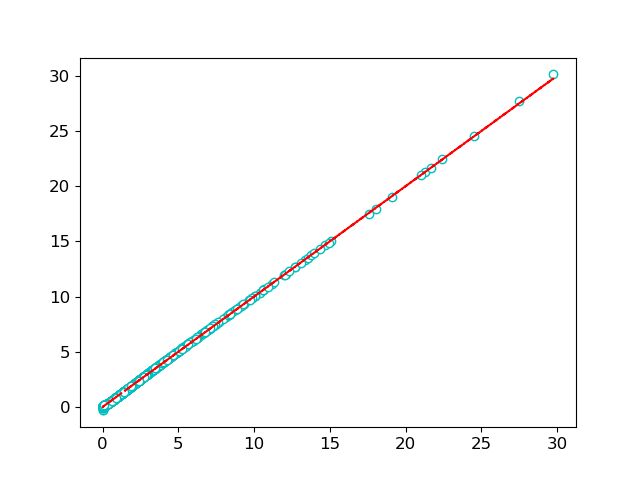

In [143]:
# polynomial regression in the reduced dimension space
poly_reg.fit(L, y_train)

# predict test set 
l_test = dpca.transform(x_test)
# print(l_test.shape)
pred = poly_reg.predict(l_test)

# plot results
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white")
plt.plot(y_test, y_test, 'r--')


In [144]:
# compare principal axis to normalized basket weights

print(dpca.n_components_) #1

axis = dpca.components_[0]
weights = bach.baskets[0].weights
normalized = (weights / np.linalg.norm(weights)).ravel()

print(np.allclose(axis, normalized)) # True

1
True


In [208]:
# test for 3 baskets

num_stocks = 20
num_baskets = 3

seed = np.random.randint(131072)
print("using training seed", seed)

bach3 = BachelierSimulator(num_stocks, num_baskets, 3, seed=seed)

# enough so we don't worry about overfitting in low dimension
num_examples = 131072

x_train, y_train, z_train = bach3.trainSet(num_examples, seed=seed)

num_test = 1024
test_seed = np.random.randint(131072)
print("using test seed", test_seed)

x_test, y_test, z_test = bach3.testSet(num_test, seed=test_seed)

using training seed 43453
using test seed 89314


In [209]:
# differential PCA

# L = latent representation in low dimension, S = dY / dL
L, S = dpca.fit_transform(x_train, z_train)

# dimension reduction

# initial
print(x_train.shape, z_train.shape) 

# reduced
print(L.shape, S.shape) 

(131072, 20) (131072, 20)
(131072, 3) (131072, 3)


<IPython.core.display.Javascript object>


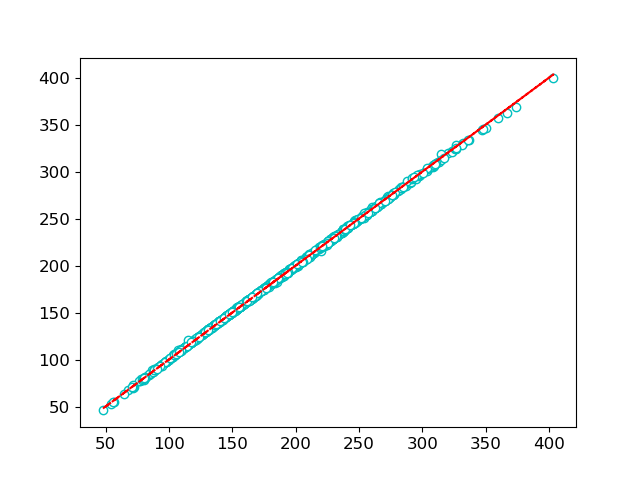

In [210]:
# polynomial regression in the reduced dimension space
poly_reg.fit(L, y_train)

# predict test set 
l_test = dpca.transform(x_test)
# print(l_test.shape)
pred = poly_reg.predict(l_test)

# compute error and plot
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white")
plt.plot(y_test, y_test, 'r--')

In [211]:
# compare principal axis to normalized basket weights

print(dpca.n_components_) #3

axes = dpca.components_.T # 3 principal components in columns
weights = np.array([basket.weights.ravel() for basket in bach3.baskets]).T # 3 normalized basket weights in columns

# check that weights and axes span the same 3-dimensional space
# since axes are orthonormal, it is sufficient to check that weights belong to their spanned space

# project weights onto axes
projected_weights = axes @ axes.T @ weights 
# check that projection error is zero
print(np.allclose(weights, projected_weights)) # True

3
True


In [390]:
# read Bermudan 5f dataset, takes around a minute to read 32,768 training examples in dimension 83 (41 yields + 1 pathwise payoff + 41 pathwise derivatives)

import pandas as pd
import time

# read train set
t0 = time.time()
# takes a while, 52.6MB file
# expect around one minute
train_set = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_train.csv", index_col=0) 
t1 = time.time()
print("train set read in %d seconds" % (t1 - t0))
print(train_set)

# read test set
test_set = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_test.csv", index_col=0)
print(test_set)

# split
labels = train_set.iloc[:, :41].columns
x_train = train_set.iloc[:, :41].to_numpy()
y_train = train_set['payoff'].to_numpy()
z_train = train_set.iloc[:, -41:].to_numpy()
x_test = test_set.iloc[:, :-1].to_numpy()
y_test = test_set.iloc[:, -1].to_numpy()

import re
maturities = np.array([float(re.search(r'\d+.\d+', label).group()) for label in labels])

train set read in 54 seconds
       yield(0.00)  yield(0.50)  yield(1.00)  yield(1.50)  yield(2.00)  \
0         0.000009     0.000008     0.000007     0.000007     0.000007   
1         0.002630     0.004541     0.005230     0.005284     0.005054   
2        -0.002613    -0.004525    -0.005215    -0.005270    -0.005041   
3        -0.003002    -0.003592    -0.003817    -0.003826    -0.003714   
4         0.007632     0.007396     0.007204     0.007006     0.006778   
...            ...          ...          ...          ...          ...   
32763     0.008723     0.000638    -0.003383    -0.005035    -0.005370   
32764    -0.004539    -0.002755    -0.001489    -0.000583     0.000071   
32765    -0.004784    -0.006232    -0.006339    -0.005703    -0.004691   
32766    -0.004176    -0.000181     0.000742     0.000094    -0.001232   
32767    -0.007623    -0.005811    -0.004073    -0.002520    -0.001197   

       yield(2.50)  yield(3.00)  yield(3.50)  yield(4.00)  yield(4.50)  ...  \
0  

In [391]:
# plot random training states (yield curve deformations along with corresponding payoffs)

num_examples = len(train_set)
num_plot = 3

indices = np.random.choice(num_examples, size=num_plot, replace=False)
x_plot = x_train.iloc[indices]
y_plot = y_train[indices]

plt.figure()
for i in range(num_plot):
    plt.plot(maturities, np.array(x_plot.iloc[i]), label="payoff=%.2f" % y_plot.iloc[i])
plt.axhline(y=0, linestyle='--')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

<IPython.core.display.Javascript object>


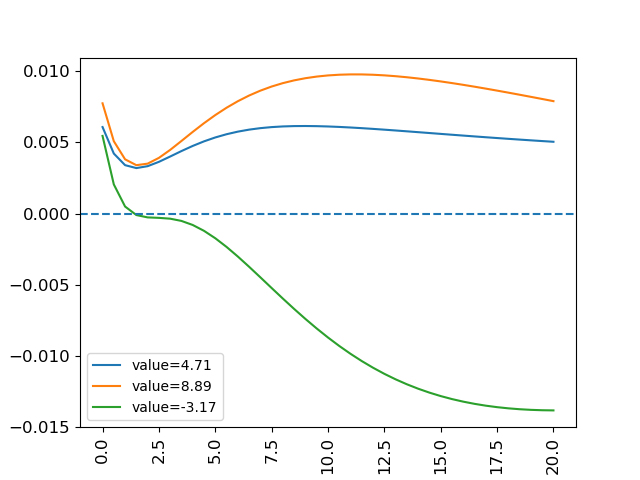

In [344]:
# plot random test states (yield curve deformations along with continuation values)

num_examples = len(test_set)
num_plot = 3

indices = np.random.choice(num_examples, size=num_plot, replace=False)
x_plot = x_test.iloc[indices]
y_plot = y_test[indices]

plt.figure()
for i in range(num_plot):
    plt.plot(maturities, np.array(x_plot.iloc[i]), label="value=%.2f" % y_plot.iloc[i])
plt.axhline(y=0, linestyle='--')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [409]:
# classic PCA

pca = PCA(one_minus_eps)
L = pca.fit_transform(x_train)

In [393]:
n = pca.n_components_
print("reduced dimension =", n)

reduced dimension = 5


<IPython.core.display.Javascript object>


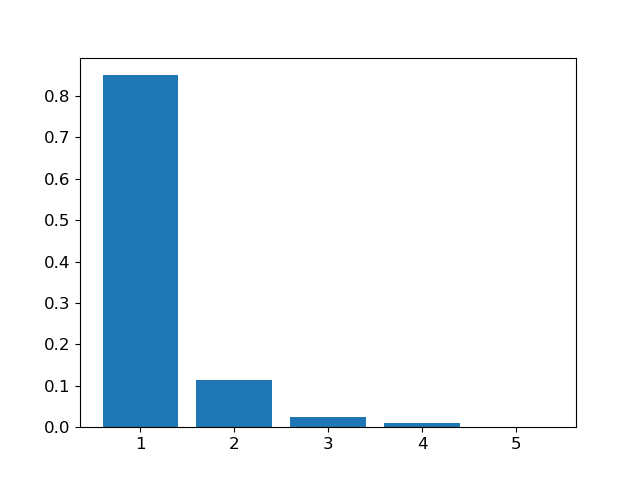

In [394]:
plt.figure()
plt.bar(range(1, n+1), pca.explained_variance_ratio_)
plt.show()

<IPython.core.display.Javascript object>


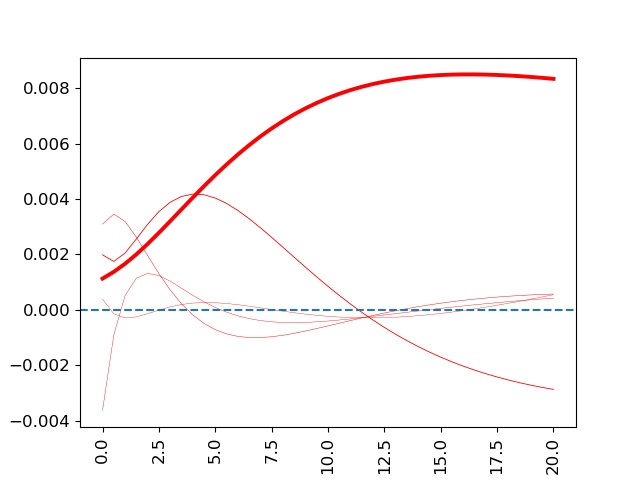

In [395]:
plt.figure()
for i in range(n):
    plt.plot(maturities, pca.components_[i] * np.sqrt(pca.explained_variance_[i]), 'r-', linewidth= 0.25 + 3 * pca.explained_variance_ratio_[i])
plt.axhline(y=0, linestyle='--')
plt.xticks(rotation=90)
plt.show()

<IPython.core.display.Javascript object>


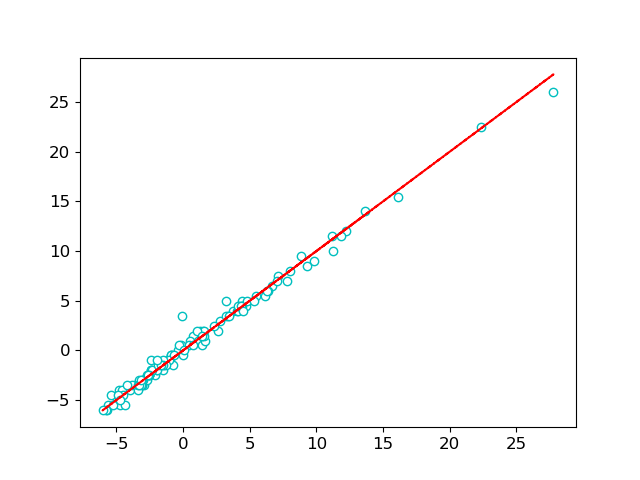

In [396]:
# polynomial regression in dimension 5
poly_reg.fit(L, y_train)

# predict test set 
l_test = pca.transform(x_test)
# print(l_test.shape)
pred = poly_reg.predict(l_test)

# compute error and plot
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white")
plt.plot(y_test, y_test, 'r--')

<IPython.core.display.Javascript object>


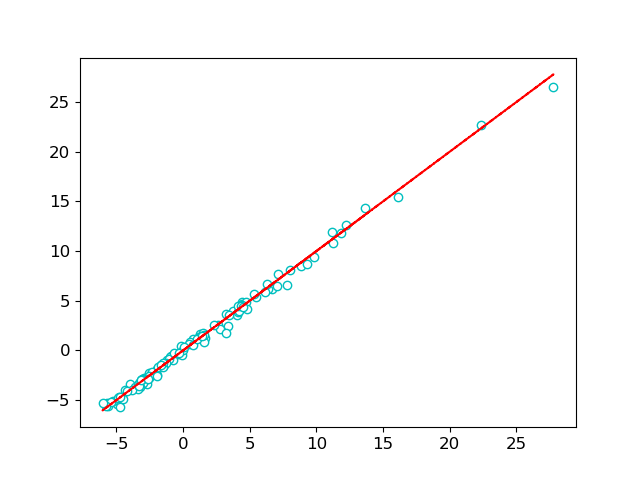

In [410]:
# polynomial regression in dimension 2
pca2 = PCA(2)
L = pca2.fit_transform(x_train)

poly_reg.fit(L, y_train)

# predict test set 
l_test = pca2.transform(x_test)
# print(l_test.shape)
pred = poly_reg.predict(l_test)

# compute error and plot
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white")
plt.plot(y_test, y_test, 'r--')

In [411]:
L

array([[-2.82084506e-07, -2.43985832e-08],
       [ 5.06863528e-02, -3.53208352e-03],
       [-5.06869169e-02,  3.53203472e-03],
       ...,
       [ 3.24705609e-02, -1.33809102e-02],
       [-5.70485999e-04, -2.45679279e-02],
       [ 9.24306305e-03,  7.99468393e-04]])

In [418]:
(x_train-x_train.mean(axis=0)) @ pca2.components_.T

array([[-2.82084507e-07, -2.43985838e-08],
       [ 5.06863528e-02, -3.53208352e-03],
       [-5.06869169e-02,  3.53203472e-03],
       ...,
       [ 3.24705609e-02, -1.33809102e-02],
       [-5.70485999e-04, -2.45679279e-02],
       [ 9.24306305e-03,  7.99468393e-04]])

In [398]:
# differential PCA

diffpca = DiffPCA(one_minus_eps)
L = diffpca.fit_transform(x_train, z_train)

In [399]:
n = diffpca.n_components_
print("reduced dimension =", n)

reduced dimension = 5


<IPython.core.display.Javascript object>


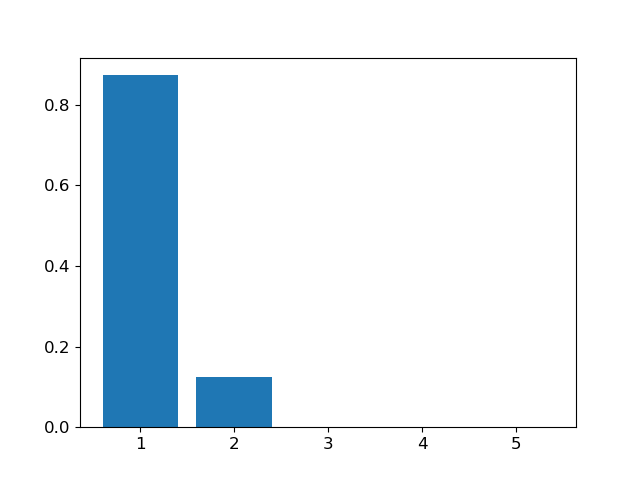

In [400]:
plt.figure()
plt.bar(range(1, n+1), diffpca.explained_variance_ratio_)
plt.show()

<IPython.core.display.Javascript object>


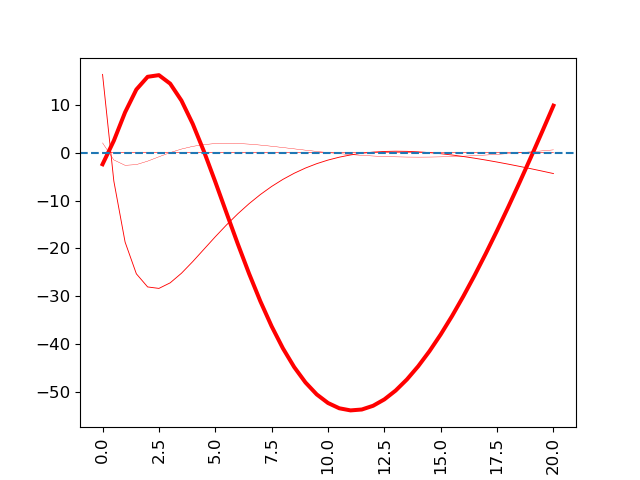

In [401]:
plt.figure()
for i in range(n):
    plt.plot(maturities, diffpca.components_[i] * np.sqrt(diffpca.explained_variance_[i]), 'r-', linewidth= 0.25 + 3 * diffpca.explained_variance_ratio_[i])
plt.axhline(y=0, linestyle='--')
plt.xticks(rotation=90)
plt.show()

<IPython.core.display.Javascript object>


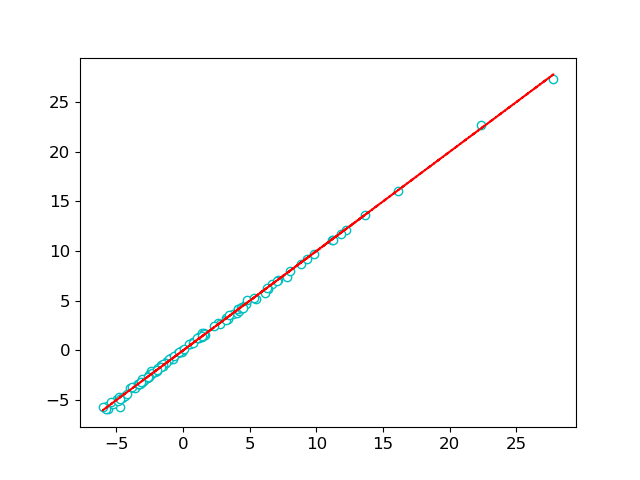

In [402]:
# polynomial regression in dimension 2
dpca2 = DiffPCA(2)
L, S = dpca2.fit_transform(x_train, z_train)

poly_reg.fit(L, y_train)

# predict test set 
l_test = dpca2.transform(x_test)
# print(l_test.shape)
pred = poly_reg.predict(l_test)

# compute error and plot
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white")
plt.plot(y_test, y_test, 'r--')